<img src="./scr/pi1_mlops_data_header.png">

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

<p>Preparacion de los datos.</p>
Ahora que tenemos integrada nuestro dataset, y disponible para consulta. Necesitamos prepararlos para que sean útiles para el sistema de recomendación. Para ello vamos vamos a integrarlos en un solo archivo, 

In [8]:
#leemos el archivo de ratings
data_users = pd.read_parquet('./datasets_parciales/ratings_final.parquet')

In [9]:
#asignamos tipos para mejorar el rendimiento en memoria
data_users['timestamp'] = data_users['timestamp'].astype('datetime64')

In [10]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11024289 entries, 0 to 1499999
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   rating     float64       
 2   timestamp  datetime64[ns]
 3   movieId    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 420.5+ MB


In [12]:
#data_users.drop('Unnamed: 0',inplace=True, axis=1)
data_users.head()

,userId,rating,timestamp,movieId
0,249182,3.5,2016-04-12,ds327
1,249182,4.0,2016-04-28,ns2124
2,249182,3.0,2016-04-09,as8841
3,249182,4.5,2016-04-09,hs2318
4,249182,2.5,2016-04-09,as5743


In [13]:
#cuántos usuarios únicos hay?
print(len(data_users['userId'].unique()))

115077


Vamos a cargar el archivo de películas por plataforma.

In [14]:
#lee el archivo de títulos
data_movies = pd.read_csv('./datasets_parciales/titles_total.csv')

In [15]:
#observamos el tamaño del archivo
data_movies.drop('Unnamed: 0',inplace=True, axis=1)
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            22998 non-null  object 
 1   title           22998 non-null  object 
 2   director        14739 non-null  object 
 3   cast            22998 non-null  object 
 4   country         11499 non-null  object 
 5   release_year    22998 non-null  int64  
 6   rating          22998 non-null  object 
 7   listed_in       22998 non-null  object 
 8   description     22994 non-null  object 
 9   id              22998 non-null  object 
 10  date_added_std  13444 non-null  object 
 11  duration_int    22998 non-null  int64  
 12  duration_type   22516 non-null  object 
 13  score           22998 non-null  float64
dtypes: float64(1), int64(2), object(11)
memory usage: 2.5+ MB


In [16]:
data_movies.head()

,type,title,director,cast,country,release_year,rating,listed_in,description,id,date_added_std,duration_int,duration_type,score
0,movie,duck the halls: a mickey mouse christmas special,"alonso ramirez ramos, dave wasson","chris diamantopoulos, tony anselmo, tress macn...",NaN,2016,tv-g,"animation, family",join mickey and the gang as they duck the halls!,ds1,2021-11-26,23,min,3.6
1,movie,ernest saves christmas,john cherry,"jim varney, noelle parker, douglas seale",NaN,1988,pg,comedy,santa claus passes his magic bag to a new st. ...,ds2,2021-11-26,91,min,3.5
2,movie,ice age: a mammoth christmas,karen disher,"raymond albert romano, john leguizamo, denis l...",united states,2011,tv-g,"animation, comedy, family",sid the sloth is on santa's naughty list.,ds3,2021-11-26,23,min,3.6
3,movie,the queen family singalong,hamish hamilton,"darren criss, adam lambert, derek hough, alexa...",NaN,2021,tv-pg,musical,"this is real life, not just fantasy!",ds4,2021-11-26,41,min,3.5
4,tv show,the beatles: get back,NaN,"john lennon, paul mccartney, george harrison, ...",NaN,2021,g,"docuseries, historical, music",a three-part documentary from peter jackson ca...,ds5,2021-11-25,1,season,3.5


Empezamos a analizar la existencia de datos nulos o inconsistentes, que nos impidan realizar una recomendación adecuada

In [17]:
data_movies.isnull().sum()

type                  0
title                 0
director           8259
cast                  0
country           11499
release_year          0
rating                0
listed_in             0
description           4
id                    0
date_added_std     9554
duration_int          0
duration_type       482
score                 0
dtype: int64

Podemos observar una gran cantidad de datos nulos en los campos director, country, date_add, porlo que no resultarían buenos candidatos para determinar el gusto de un usuario por una película en particular.

Una vez concluido lo anterior, revisaremos la consistencia del resto de los campos a efecto de encontrar candidatos que influyan en la predicción.

In [18]:
##observamos el universo de valores de la variable score
data_movies['score'].value_counts()

3.5    13564
3.6     8269
3.4      976
3.7      185
3.3        4
Name: score, dtype: int64

In [19]:
#data_movies[data_movies['id']=='as4127']
print(data_movies.loc[data_movies['id']=='as4127']['title'].str.strip())

5576    pale blue moon
Name: title, dtype: object


Vamos a revisar las calificaciones de las películas por usuario, recordemos que son 115,077 usuarios diferentes

In [20]:
data_by_users = data_users.groupby(['userId']).count().sort_values(by='rating',ascending = False)
data_by_users.head()

,rating,timestamp,movieId
userId,,,
45811,18276,18276,18276
8659,9279,9279,9279
270123,7638,7638,7638
70648,5356,5356,5356
24025,4946,4946,4946


In [51]:
data_by_users.shape

(115077, 3)

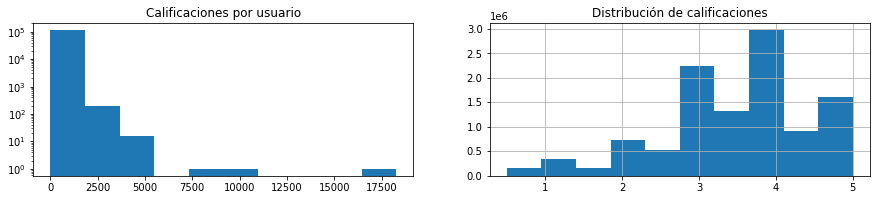

In [21]:
plt.figure(figsize=(15,50))

plt.subplot(15,2,1)
plt.hist(data_by_users.rating, log= True)
plt.title('Calificaciones por usuario')

plt.subplot(15,2,2)
data_users['rating'].hist()
plt.title('Distribución de calificaciones')
plt.show()

In [22]:
#qué película es la que mas calificaciones tiene y cuál es la que menos tiene?
data_by_movies = data_users.groupby(['movieId']).count()
#data_by_movies.head()
idx_max = data_by_movies['userId'].idxmax()
print('Película con mas calificaciones : ')
print(data_movies.loc[data_movies['id']==idx_max].title)
idx_min = data_by_movies['userId'].idxmin()
print('Película con menos calificaciones : ')
print(data_movies.loc[data_movies['id']==idx_min].title)

Película con mas calificaciones : 
5646    from other worlds
Name: title, dtype: object
Película con menos calificaciones : 
6389    mitzi (nbc 1968)
Name: title, dtype: object


In [23]:
#Vamos a mostrar las películas por popularidad
#primero sacamos un conteo de movieId de las películas mas valoradas con 5.0
data_mas_valoradas = data_users[data_users['rating']==5.0].groupby('movieId').count().sort_values(by='userId',ascending=False)
data_mas_valoradas.head()

,userId,rating,timestamp
movieId,,,
ns8168,108,108,108
as5312,107,107,107
as7644,104,104,104
as7249,104,104,104
as2553,102,102,102


In [24]:
data_mas_valoradas.index

Index(['ns8168', 'as5312', 'as7644', 'as7249', 'as2553', 'ns7296', 'ds199',
       'hs1007', 'ns7987', 'as8275',
       ...
       'ds994', 'as9059', 'as8885', 'as8266', 'ns6045', 'as8336', 'ns8250',
       'ds978', 'as7617', 'ns3618'],
      dtype='object', name='movieId', length=22998)

In [25]:
data_mas_valoradas

,userId,rating,timestamp
movieId,,,
ns8168,108,108,108
as5312,107,107,107
as7644,104,104,104
as7249,104,104,104
as2553,102,102,102
...,...,...,...
as8336,43,43,43
ns8250,43,43,43
ds978,43,43,43


In [26]:
#borramos las columnas que no necesitamos
data_mas_valoradas.drop(['userId','timestamp'],axis=1,inplace=True)
#renombramos la columna para mejor lectura
data_mas_valoradas.rename(columns = {'rating':'valoraciones'}, inplace=True)
#ahora le pegamos el título de la película desdes data_movies y graficamos

data_mas_valoradas = pd.merge(left=data_mas_valoradas,right=data_movies[['id','title']], how='left', left_on=data_mas_valoradas.index, right_on='id')
data_mas_valoradas.head()

,valoraciones,id,title
0,108,ns8168,terminator salvation
1,107,as5312,vivarium
2,104,as7644,born kicking
3,104,as7249,49-o
4,102,as2553,enchantimals


In [27]:
data_mas_valoradas.tail(20)

,valoraciones,id,title
22978,46,as2036,jeremiah
22979,46,as3248,animal babies: first year on earth
22980,46,as2128,ilana glazer: the planet is burning
22981,46,ns7700,palio
22982,46,as38,"you, me and him"
22983,46,ns8788,you can’t fight christmas
22984,46,as8244,the omen
22985,46,ns7909,russell peters vs. the world
22986,45,as167,waiting for lightning
22987,45,hs757,the indian in the cupboard


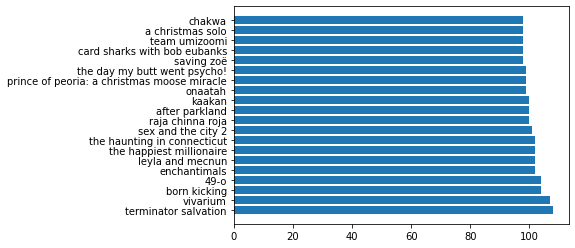

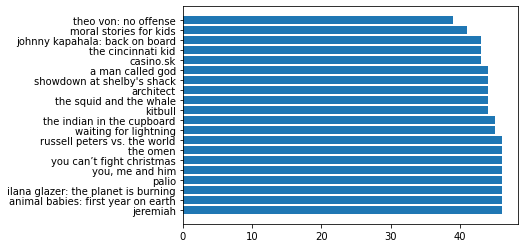

In [28]:
fig, ax =plt.subplots()
ax.barh(data_mas_valoradas['title'].head(20),data_mas_valoradas['valoraciones'].head(20),label='Películas mas puntuadas')

fig, ax =plt.subplots()
ax.barh(data_mas_valoradas['title'].tail(20),data_mas_valoradas['valoraciones'].tail(20),label='Películas menos puntuadas')

plt.show()

pero, ¿cómo están distribuídas esas valoraciones? cuáles el rango de películas 
mas o menos vistas. en las gŕaficas anteriores no se alcanza a apreciar, hagamos entonces un 
gráfico de distribución

<Figure size 1152x576 with 0 Axes>

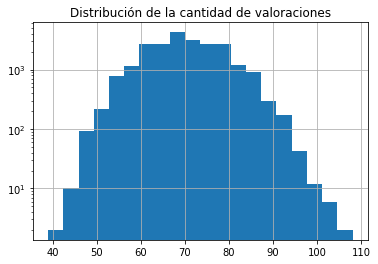

In [29]:
plt.figure(figsize = (16,8))
#guarda el filtro
data_mas_valoradas.hist(log = True, bins = 20)
plt.title('Distribución de la cantidad de valoraciones')

plt.show()

Como podemos observar, las películas valoradas estan en el rango de 55 a 90 valoraciones de diferentes usuarios, por lo que será el universo de peliculas a considerar para nuestro sistema de recomendaciones.

Procedemos a armar los filtros para seleccionar los registros

In [30]:
data_mas_valoradas.shape

(22998, 3)

In [31]:
#registros considerados
lim_inferior = 55
lim_superior = 85
data_mas_valoradas[(data_mas_valoradas['valoraciones']>=lim_inferior) & (data_mas_valoradas['valoraciones']<=lim_superior)]

,valoraciones,id,title
890,85,hs553,the mighty ones
891,85,as5126,corporate prey
892,85,ds49,space buddies
893,85,as2067,jackpot (tamil)
894,85,hs2941,the odd couple
...,...,...,...
22372,55,ns6067,a young doctor's notebook and other stories
22373,55,as9574,the shadow
22374,55,as3142,bastard's crossing
22375,55,ns5349,close your eyes before it’s dark


Tenemos 21,487 películas que recibieron valoraciones por parte de los usuarios y que serán consideradas para ser evaluadas en el modelo del sistema recomendaciones.

Generamos una serie con los id de las películas que quedan fuera del filtro para eliminarlos del universo de valoraciones de los usuarios que será utilizado en el siguinte módulo.

In [32]:
data_no_considerados = data_mas_valoradas[(data_mas_valoradas['valoraciones']<lim_inferior) | (data_mas_valoradas['valoraciones']>lim_superior)]['id']
data_no_considerados.to_csv('./datasets_parciales/moviesId_noconsideradas.csv')

In [33]:
data_no_considerados.shape

(1511,)

In [34]:
#Crearemos un archivo solo con los registros probales a usar en el siguiente módulo. 
# a los usuarios hay que quitarle las valoraciones de data_no_considerada
data_final = data_users[~data_users['movieId'].isin(data_no_considerados)]
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10294674 entries, 0 to 1499999
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   rating     float64       
 2   timestamp  datetime64[ns]
 3   movieId    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 392.7+ MB


In [36]:
#guardamos el archivo final
data_final.to_parquet('./datasets_parciales/valoraciones_para_modelo.parquet')

In [37]:
data_final.shape

(10294674, 4)

Por mera curiosidad, vamos a sacar una tabla de correlación entre el número de visualizaciones y la calificación.

Primero hay que traernos el score promedio, justo como nos trajimos el nombre de la pelicula.

In [38]:
data_mas_valoradas.head()

,valoraciones,id,title
0,108,ns8168,terminator salvation
1,107,as5312,vivarium
2,104,as7644,born kicking
3,104,as7249,49-o
4,102,as2553,enchantimals


In [39]:
data_movies[['id','score']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      22998 non-null  object 
 1   score   22998 non-null  float64
dtypes: float64(1), object(1)
memory usage: 359.5+ KB


In [40]:
data_mas_valoradas = pd.merge(left=data_mas_valoradas,right=data_movies[['id','score']], how='left', left_on=data_mas_valoradas.id, right_on='id')
data_mas_valoradas

,id,valoraciones,id_x,title,id_y,score
0,ns8168,108,ns8168,terminator salvation,ns8168,3.6
1,as5312,107,as5312,vivarium,as5312,3.6
2,as7644,104,as7644,born kicking,as7644,3.7
3,as7249,104,as7249,49-o,as7249,3.6
4,as2553,102,as2553,enchantimals,as2553,3.6
...,...,...,...,...,...,...
22993,as8336,43,as8336,casino.sk,as8336,3.5
22994,ns8250,43,ns8250,the cincinnati kid,ns8250,3.5
22995,ds978,43,ds978,johnny kapahala: back on board,ds978,3.5
22996,as7617,41,as7617,moral stories for kids,as7617,3.4


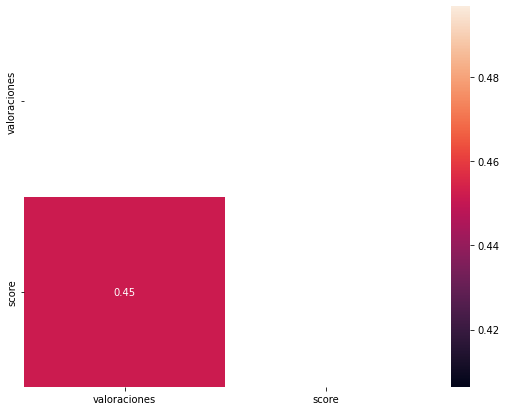

In [41]:
#observamos si hay correlación entre las variables numéricas de la valoración del usuario y el score promedio de la película
corrPeliculas = data_mas_valoradas.corr()
#para visualizar mejor haremos un mapa de calor
ax = plt.subplots(figsize=(9,7))
mask = np.zeros_like(corrPeliculas)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corrPeliculas,annot=True,mask = mask)

Procedemos a revisar la calidad de las variables tipo cadena, a efecto de determinar si podemos ponderarlas

In [27]:
#iniciamos 'type', 'title', 'director', 'cast', 'country', 'rating', 'listed_in', 'id','date_added_std', 'duration_type'
#data_movies['type'].value_counts() --> ok solo dos categorías
#data_movies['director'].value_counts() #-->>incolsistencias: lista separada por comas, nulos, números
#data_movies['cast'].value_counts().head(20) #-->>incolsistencias: números, lista separada por comas : 16745 categorías
#data_movies['country'].value_counts() #-->> es la columna con mas nulos del dataset y tiene 886 categorías
#data_movies['rating'].value_counts().head(20)   # -->> inconsistencias. son demasiadas categorías 105, tiene mezclados datos de duration
data_movies['listed_in'].value_counts().head(10) #-->> inconsistencias, lista separada por comas,1687 categorías diferentes
#data_movies['date_added_std'].value_counts() 
#data_movies['duration_type'].value_counts() #--> categoria "season" en plural y en singular. 

drama                           1061
comedy                           608
documentaries                    573
comedy, drama                    421
drama, suspense                  399
documentary                      375
animation, kids                  373
kids                             367
dramas, international movies     362
stand-up comedy                  334
Name: listed_in, dtype: int64

In [49]:
#vamos a contar cuantos valores diferentes de género encontramos y ver si podemos unificarlos,
#  porque el género si influye en el gusto de la persona
data_Genero = pd.DataFrame(data_movies['listed_in'].str.split(',',expand=True).to_numpy().flatten(),columns={'genero'})
data_Genero['genero']=data_Genero['genero'].str.strip()
#data_Genero['genero'].value_counts()
data_Genero['genero'].value_counts().head(20)

drama                     4728
comedy                    3292
international movies      2752
dramas                    2427
action                    2212
comedies                  1674
suspense                  1501
documentaries             1393
kids                      1388
international tv shows    1351
horror                    1179
documentary               1167
animation                 1089
special interest           980
romance                    880
action & adventure         859
family                     837
adventure                  815
tv dramas                  763
independent movies         756
Name: genero, dtype: int64

In [50]:
#vamos a contar los valores únicos del gébnero de la película, porque puede ser un buen indicador del gusto del usuario
# Usuarios únicos

print(len(data_Genero['genero'].unique()))

121


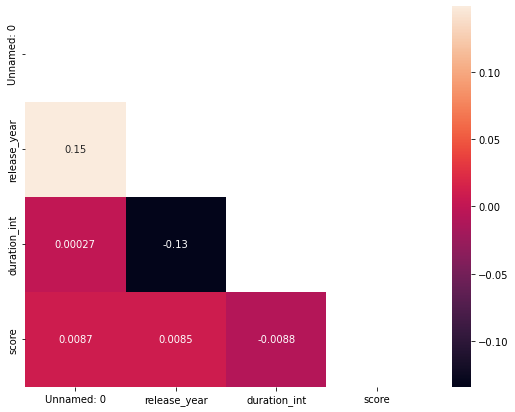

In [13]:
#observamos si hay correlación entre las variables numéricas
corrPeliculas = data_movies.corr()
#para visualizar mejor haremos un mapa de calor
ax = plt.subplots(figsize=(9,7))
mask = np.zeros_like(corrPeliculas)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corrPeliculas,annot=True,mask = mask)

Observamos que NO hay una correlación entre las variables numéricas.

In [17]:
cols = data_movies.columns.values
col_num = 3
row_num = int(len(cols)-1/col_num)
print(row_num)

14


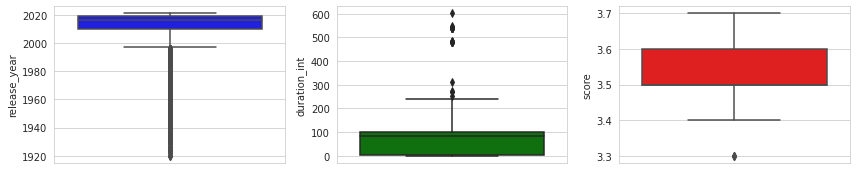

In [58]:
#Vamos por los valores atípicos de las variables numéricas

plt.figure(figsize=(12,35))

plt.subplot(15,3,1)
sns.boxplot(y=data_movies['release_year'],color='blue',orient='v')
plt.tight_layout()

plt.subplot(15,3,2)
sns.boxplot(y=data_movies['duration_int'],color='green',orient='v')
plt.tight_layout()

plt.subplot(15,3,3)
sns.boxplot(y=data_movies['score'],color='red',orient='v')
plt.tight_layout()


Podemos observar que se encuentran datos atípicos en las categorías de  año de publicación (release_year) y duración (duration_int), no así en el score que tiene una distribución muy corta. por lo que podemos asumir que en las dos primeras categorías los datos no tienen una distribución normal.

<AxesSubplot:xlabel='score', ylabel='Count'>

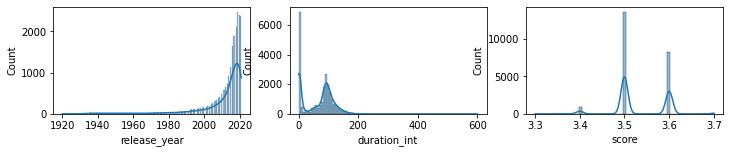

In [3]:
plt.figure(figsize=(12,35))

plt.subplot(15,3,1)
sns.histplot(data_movies['release_year'],kde=True)

plt.subplot(15,3,2)
sns.histplot(data_movies['duration_int'],kde=True)

plt.subplot(15,3,3)
sns.histplot(data_movies['score'],kde=True)



In [15]:
#lee el archivo de títulos
data_ratings = pd.read_csv('./MLOpsReviews/ratings/ratings_final.csv')

In [30]:
data_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11024289 entries, 0 to 11024288
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   userId      int64  
 2   rating      float64
 3   timestamp   object 
 4   movieId     object 
dtypes: float64(1), int64(2), object(2)
memory usage: 420.5+ MB


In [31]:
data_ratings.describe()

,Unnamed: 0,userId,rating
count,1.102429e+07,1.102429e+07,1.102429e+07
mean,7.267983e+05,8.997251e+04,3.533455e+00
std,4.364091e+05,8.686601e+04,1.059692e+00
min,0.000000e+00,1.000000e+00,5.000000e-01
25%,3.445090e+05,2.855800e+04,3.000000e+00
50%,7.125500e+05,5.684300e+04,3.500000e+00
75%,1.106275e+06,1.168670e+05,4.000000e+00
max,1.499999e+06,2.708960e+05,5.000000e+00


Concluimos que usaremos las variables de calificaciones proporcionadas por el usuario para hacerle una recomendación en el siguiente módulo.